<a href="https://colab.research.google.com/github/PrathicaShettyM/AgriculturalLandDetection/blob/main/LandCoverClassificationForAgriculture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nilesh789_eurosat_rgb_path = kagglehub.dataset_download('nilesh789/eurosat-rgb')

print('Data source import complete.')


100%|██████████| 89.6M/89.6M [00:03<00:00, 25.5MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prathicashettym","key":"d89eed21f1b9a44c2834bc42ac8c0a02"}'}

In [ ]:
# Move it to the correct directory and fix permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d apollo2506/eurosat-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [00:22<00:00, 239MB/s]
100% 2.04G/2.04G [00:22<00:00, 96.6MB/s]


In [ ]:
!unzip eurosat-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: EuroSATallBands/River/River_1990.tif  
  inflating: EuroSATallBands/River/River_1991.tif  
  inflating: EuroSATallBands/River/River_1992.tif  
  inflating: EuroSATallBands/River/River_1993.tif  
  inflating: EuroSATallBands/River/River_1994.tif  
  inflating: EuroSATallBands/River/River_1995.tif  
  inflating: EuroSATallBands/River/River_1996.tif  
  inflating: EuroSATallBands/River/River_1997.tif  
  inflating: EuroSATallBands/River/River_1998.tif  
  inflating: EuroSATallBands/River/River_1999.tif  
  inflating: EuroSATallBands/River/River_2.tif  
  inflating: EuroSATallBands/River/River_20.tif  
  inflating: EuroSATallBands/River/River_200.tif  
  inflating: EuroSATallBands/River/River_2000.tif  
  inflating: EuroSATallBands/River/River_2001.tif  
  inflating: EuroSATallBands/River/River_2002.tif  
  inflating: EuroSATallBands/River/River_2003.tif  
  inflating: EuroSATallBands/River/River_2004.tif  
  inflating: EuroSA

# Land-Cover Classification with EuroSAT Dataset


![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)



In this notebook we will tackle the problem of land-use and land-cover classification where we try to identify the class of given remote sensing image based on some well defined target class labels. For training the model we will use the EuroSAT dataset from this [paper](https://arxiv.org/abs/1709.00029) published in 2019 which is now a standard benchmark for land-cover classification task.

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over **27000 images** spread across **10 classes**. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels downloaded from [here](http://madm.dfki.de/files/sentinel/EuroSAT.zip).

The paper states that the finetuned CNN model **ResNet50** performed best with 80-20 split on the data for RGB channels giving about **98.57%** accuracy.

Finally, this notebook was forked and edited from [here](https://www.kaggle.com/silentj23/eurosat-image-classification#II.-Preprocessing).

**NOTE:** This notebook is still a work in progress so expect a final version soon

In [ ]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# I. Data Exploration

In this project, I'll be exploring the EUROSAT dataset. The EUROSAT dataset is composed of images taken from the Sentinel-2 satellite. This dataset lists images of the earth's surface into 10 different land cover labels. For this project, I will build an image classification model for predicting a land cover label, given an image.

In [ ]:
DATASET = "/content/EuroSAT"


LABELS = [name for name in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, name))]
print("Class labels:", LABELS)

Class labels: ['Residential', 'PermanentCrop', 'Pasture', 'River', 'AnnualCrop', 'Industrial', 'SeaLake', 'Highway', 'HerbaceousVegetation', 'Forest']


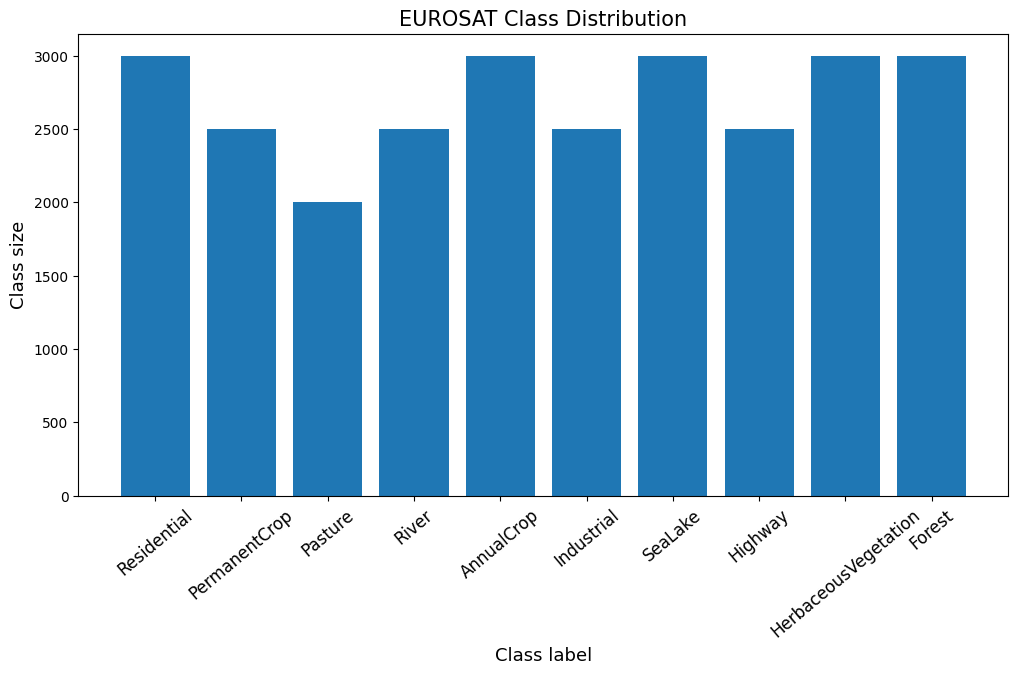

In [ ]:
# ✅ Count images per class
counts = {}
for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

# ✅ Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('Class label', fontsize=13)
plt.ylabel('Class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15)
plt.show()

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets.

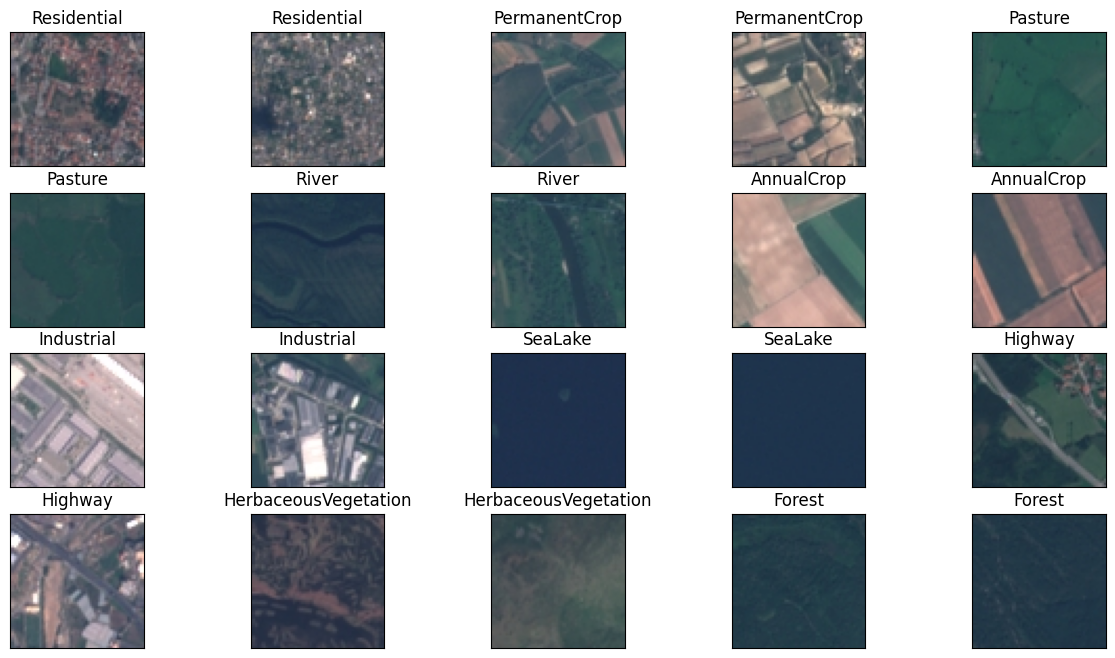

In [ ]:
from PIL import Image

# 📁 Dataset folder and class labels (directories only)
DATASET = "/content/EuroSAT"
LABELS = [name for name in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, name))]

# ✅ Safely collect existing sample image paths
img_paths = []

for l in LABELS:
    path1 = os.path.join(DATASET, l, l + '_1000.jpg')
    path2 = os.path.join(DATASET, l, l + '_2000.jpg')
    if os.path.exists(path1):
        img_paths.append(path1)
    if os.path.exists(path2):
        img_paths.append(path2)

# ✅ Plot the images
def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(min(20, len(paths))):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = Image.open(paths[i])
        plt.imshow(np.asarray(img))
        class_name = os.path.basename(os.path.dirname(paths[i]))
        plt.title(class_name)

plot_sat_imgs(img_paths)


Looking at the preview of the different classes, we can see some similarities and stark differences between the classes.

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways.

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields.

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances.

Sentinel-2 satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data.

# II. Preprocessing

I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories.

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training.

In [ ]:
!pip install keras

In [ ]:
import os
import re
import shutil
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # ✅ Correct import

# Class Definitions
LABELS = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
          'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
SUITABLE_CLASSES = ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']

# Paths - 🔥 keeping your exact structure
DATASET = '/content/EuroSAT'
TRAIN_DIR = '/content/training'
TEST_DIR = '/content/testing'
BATCH_SIZE = 64
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'binary'  # Binary classification

# ✅ Create training/testing folders with 'Suitable' and 'Unsuitable'
for path in (TRAIN_DIR, TEST_DIR):
    os.makedirs(os.path.join(path, 'Suitable'), exist_ok=True)
    os.makedirs(os.path.join(path, 'Unsuitable'), exist_ok=True)

# ✅ Map each image to binary label
data = {}
for l in LABELS:
    label_dir = os.path.join(DATASET, l)
    label = 'Suitable' if l in SUITABLE_CLASSES else 'Unsuitable'
    for img in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img)
        data[img_path] = label

# ✅ Stratified split
X = pd.Series(list(data.keys()))
y = pd.Series(list(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

for train_idx, test_idx in split.split(X, y):
    train_paths = X.iloc[train_idx]
    test_paths = X.iloc[test_idx]

    new_train_paths = [os.path.join(TRAIN_DIR, data[path], os.path.basename(path)) for path in train_paths]
    new_test_paths = [os.path.join(TEST_DIR, data[path], os.path.basename(path)) for path in test_paths]

    print("Moving training files...")
    for src, dest in tqdm(zip(train_paths, new_train_paths)):
        if not os.path.exists(dest):
            shutil.copy(src, dest)

    print("Moving testing files...")
    for src, dest in tqdm(zip(test_paths, new_test_paths)):
        if not os.path.exists(dest):
            shutil.copy(src, dest)



Moving training files...


21600it [00:15, 1368.71it/s]


Moving testing files...


5400it [00:01, 3860.02it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 2 classes.
Found 5400 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'Suitable': 0, 'Unsuitable': 1}


In [ ]:
np.save('class_indices', train_generator.class_indices)

# III. Machine Learning for Image Classification

First, we will see how a machine learning model performs by directly feeding it the whole image pixels (64x64x3 = 12288). From our 80-20 split on the 27000 samples dataset the training data is of size 21600 and test data is of size 5400. Now, here I will use some trick to utilize keras ImageDataGenerator such that we can obtain the image dataset as a numpy array which can be used by a machine learning model for training and testing.

Now, here I will test Random Forest Classifier. First by using the direct implementation provided by scikit-learn and other implemented from scratch. This notebook is a part of my course project because of which I have included this additional implementation from scratch. Feel free to check it out or you can skip over it if you want.


In [ ]:
# Using image data generator api in keras for making image dataset
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 2 classes.
Found 5400 images belonging to 2 classes.


In [ ]:
# Load full training data
train = next(rf_train_generator)
X_train = train[0].reshape(train[0].shape[0], -1)
y_train = train[1]

# Load full test data
test = next(rf_test_generator)
X_test = test[0].reshape(test[0].shape[0], -1)
y_test = test[1]


### 1. Random Forest Scikit-Learn Implementation

In [ ]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train random forest
rf_clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)

# Predict and evaluate
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Random Forest Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Unsuitable', 'Suitable']))

Random Forest Accuracy: 0.8380

Classification Report:

              precision    recall  f1-score   support

  Unsuitable       0.79      0.79      0.79      2100
    Suitable       0.87      0.87      0.87      3300

    accuracy                           0.84      5400
   macro avg       0.83      0.83      0.83      5400
weighted avg       0.84      0.84      0.84      5400



# IV. Deep Learning For Image Classification

Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin.
The authors achieved an accuracy of 98.57% using a fine tuned ResNet50 model.


In [ ]:
!pip install tensorflow

In [ ]:
# Cell 1: Import Required Libraries (Cleaned for ResNet50 only)
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet50
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cell 2: GPU Setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)
tf.config.set_soft_device_placement(True)

# Cell 3: Model Compile and Utility Functions
def compile_resnet50_model(input_shape, n_classes, optimizer, fine_tune=None):
    conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    top_model = Flatten()(conv_base.output)
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def display_results(y_true, y_preds, class_labels):
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds), columns=class_labels).T
    results.rename(columns={0: 'Precision', 1: 'Recall', 2: 'F-Score', 3: 'Support'}, inplace=True)
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), columns=class_labels, index=class_labels)
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat

# Cell 4: Training Configuration
N_STEPS = train_generator.samples // BATCH_SIZE
N_VAL_STEPS = test_generator.samples // BATCH_SIZE
N_EPOCHS = 100

checkpoint = ModelCheckpoint(filepath='model.weights.best.keras',
                             monitor='val_categorical_accuracy',
                             save_best_only=True,
                             verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                              factor=0.5,
                              patience=3,
                              min_lr=0.00001)


## 4.1 ResNet50 Model

In [ ]:
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Constants
INPUT_SHAPE = (64, 64, 3)
BATCH_SIZE = 32
NUM_CLASSES = 2

# Reusable compile function
def compile_resnet50_model(input_shape, n_classes, optimizer, fine_tune=None):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    if fine_tune is None:
        base_model.trainable = False
    else:
        for layer in base_model.layers[:fine_tune]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune:]:
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

def plot_history(history):
    plt.plot(history.history['categorical_accuracy'], label='Train Acc')
    plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.show()



In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory='training',
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    directory='training',
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

N_STEPS = train_generator.samples // BATCH_SIZE
N_VAL_STEPS = test_generator.samples // BATCH_SIZE



Found 17280 images belonging to 2 classes.
Found 4320 images belonging to 2 classes.


In [ ]:
# Initial compile with frozen conv layers
resnet50_model = compile_resnet50_model(
    input_shape=INPUT_SHAPE,
    n_classes=NUM_CLASSES,
    optimizer=Adam(learning_rate=1e-3),
    fine_tune=None
)

# Callbacks
checkpoint = ModelCheckpoint(filepath='ResNet50_agri_best.keras',
                             monitor='val_categorical_accuracy',
                             save_best_only=True,
                             verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                              factor=0.5,
                              patience=3,
                              min_lr=0.00001)


In [ ]:
# 1
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=4,
    callbacks=[early_stop, checkpoint],
    validation_data=test_generator,
    validation_steps=N_VAL_STEPS,
    initial_epoch=0
)



Epoch 1/4
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - categorical_accuracy: 0.5786 - loss: 0.6996
Epoch 1: val_categorical_accuracy improved from -inf to 0.61111, saving model to ResNet50_agri_best.keras
540/540 ━━━━━━━━━━━━━━━━━━━━ 349s 627ms/step - categorical_accuracy: 0.5786 - loss: 0.6995 - val_categorical_accuracy: 0.6111 - val_loss: 0.6975
Epoch 2/4
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - categorical_accuracy: 0.6010 - loss: 0.6482
Epoch 2: val_categorical_accuracy did not improve from 0.61111
540/540 ━━━━━━━━━━━━━━━━━━━━ 339s 628ms/step - categorical_accuracy: 0.6009 - loss: 0.6482 - val_categorical_accuracy: 0.2329 - val_loss: 0.7031
Epoch 3/4
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - categorical_accuracy: 0.6062 - loss: 0.6413
Epoch 3: val_categorical_accuracy did not improve from 0.61111
540/540 ━━━━━━━━━━━━━━━━━━━━ 341s 631ms/step - categorical_accuracy: 0.6062 - loss: 0.6413 - val_categorical_accuracy: 0.6111 - val_loss: 0.6918
Epoch 4/4
540/540 ━━━━━━━━━━━━━━━━━━

In [ ]:
# 2
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=8,
    callbacks=[early_stop, checkpoint],
    validation_data=test_generator,
    validation_steps=N_VAL_STEPS,
    initial_epoch=4
)

Epoch 5/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - categorical_accuracy: 0.5990 - loss: 0.6544
Epoch 5: val_categorical_accuracy improved from 0.61111 to 0.65046, saving model to ResNet50_agri_best.keras
540/540 ━━━━━━━━━━━━━━━━━━━━ 340s 629ms/step - categorical_accuracy: 0.5990 - loss: 0.6544 - val_categorical_accuracy: 0.6505 - val_loss: 0.7052
Epoch 6/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - categorical_accuracy: 0.5997 - loss: 0.6421
Epoch 6: val_categorical_accuracy did not improve from 0.65046
540/540 ━━━━━━━━━━━━━━━━━━━━ 335s 621ms/step - categorical_accuracy: 0.5997 - loss: 0.6421 - val_categorical_accuracy: 0.6111 - val_loss: 0.7013
Epoch 7/8
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - categorical_accuracy: 0.6101 - loss: 0.6327
Epoch 7: val_categorical_accuracy did not improve from 0.65046
540/540 ━━━━━━━━━━━━━━━━━━━━ 381s 620ms/step - categorical_accuracy: 0.6101 - loss: 0.6327 - val_categorical_accuracy: 0.6111 - val_loss: 0.6896
Epoch 8/8
540/540 ━━━━━━━━━━━━━━━

In [ ]:
# 3
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=12,
    callbacks=[early_stop, checkpoint],
    validation_data=test_generator,
    validation_steps=N_VAL_STEPS,
    initial_epoch=8
)


Epoch 9/12
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - categorical_accuracy: 0.6069 - loss: 0.6396
Epoch 9: val_categorical_accuracy did not improve from 0.65046
540/540 ━━━━━━━━━━━━━━━━━━━━ 359s 663ms/step - categorical_accuracy: 0.6069 - loss: 0.6396 - val_categorical_accuracy: 0.6116 - val_loss: 0.7018
Epoch 10/12
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - categorical_accuracy: 0.6151 - loss: 0.6323
Epoch 10: val_categorical_accuracy improved from 0.65046 to 0.65880, saving model to ResNet50_agri_best.keras
540/540 ━━━━━━━━━━━━━━━━━━━━ 354s 655ms/step - categorical_accuracy: 0.6151 - loss: 0.6323 - val_categorical_accuracy: 0.6588 - val_loss: 0.7034
Epoch 11/12
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - categorical_accuracy: 0.6112 - loss: 0.6333
Epoch 11: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 362s 618ms/step - categorical_accuracy: 0.6112 - loss: 0.6333 - val_categorical_accuracy: 0.2405 - val_loss: 0.7129
Epoch 12/12
540/540 ━━━━━━

In [ ]:
# 4
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=16,
    callbacks=[early_stop, checkpoint],
    validation_data=test_generator,
    validation_steps=N_VAL_STEPS,
    initial_epoch=12
)

Epoch 13/16
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - categorical_accuracy: 0.6007 - loss: 0.6391
Epoch 13: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 343s 635ms/step - categorical_accuracy: 0.6007 - loss: 0.6391 - val_categorical_accuracy: 0.3470 - val_loss: 0.7305
Epoch 14/16
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - categorical_accuracy: 0.6050 - loss: 0.6319
Epoch 14: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 354s 656ms/step - categorical_accuracy: 0.6050 - loss: 0.6319 - val_categorical_accuracy: 0.3141 - val_loss: 0.7217
Epoch 15/16
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - categorical_accuracy: 0.6027 - loss: 0.6308
Epoch 15: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 363s 621ms/step - categorical_accuracy: 0.6027 - loss: 0.6308 - val_categorical_accuracy: 0.3368 - val_loss: 0.7278
Epoch 16/16
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - categorical_a

In [ ]:
# 5
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    validation_data=test_generator,
    validation_steps=N_VAL_STEPS,
    initial_epoch=16
)


Epoch 17/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - categorical_accuracy: 0.6033 - loss: 0.6367
Epoch 17: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 337s 625ms/step - categorical_accuracy: 0.6033 - loss: 0.6367 - val_categorical_accuracy: 0.3991 - val_loss: 0.7078
Epoch 18/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - categorical_accuracy: 0.6082 - loss: 0.6293
Epoch 18: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 399s 657ms/step - categorical_accuracy: 0.6082 - loss: 0.6293 - val_categorical_accuracy: 0.6148 - val_loss: 0.6999
Epoch 19/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - categorical_accuracy: 0.6030 - loss: 0.6332
Epoch 19: val_categorical_accuracy did not improve from 0.65880
540/540 ━━━━━━━━━━━━━━━━━━━━ 339s 629ms/step - categorical_accuracy: 0.6030 - loss: 0.6332 - val_categorical_accuracy: 0.6111 - val_loss: 0.6873
Epoch 20/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - categorical_a

In [ ]:
!ls


class_indices.npy    kaggle.json			     testing
EuroSAT		     ResNet50_agri_best.keras		     training
EuroSATallBands      ResNet50_agriculture_suitability.keras
eurosat-dataset.zip  sample_data


In [ ]:
import numpy as np
import os
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# === 1. Load the best weights after full training ===
resnet50_model.load_weights('ResNet50_agri_best.keras')

# === 2. Save the final model in .keras format ===
resnet50_model.save('ResNet50_agriculture_suitability.keras')
print("✅ Model saved as ResNet50_agriculture_suitability.keras")

# === 3. Prepare test data generator from 'testing' folder ===
test_gen = ImageDataGenerator(rescale=1./255)
test_generator_new = test_gen.flow_from_directory(
    directory='testing',
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# === 4. Make predictions ===
predictions = resnet50_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(predictions, axis=1)

# === 5. Load class label mapping from training generator ===
# Assuming you already have this saved earlier:
# np.save('class_indices.npy', train_generator.class_indices)
class_indices = np.load('class_indices.npy', allow_pickle=True).item()

# Invert the mapping to get labels
label_map = {v: k for k, v in class_indices.items()}
label_names = [label_map[idx] for idx in predicted_classes]

# === 6. Print predictions ===
for filename, label in zip(test_generator_new.filenames, label_names):
    print(f"{filename} => {label}")

# === 7. (Optional) Save predictions to a file ===
with open("final_predictions.txt", "w") as f:
    for filename, label in zip(test_generator_new.filenames, label_names):
        f.write(f"{filename} => {label}\n")

print("✅ All done! Predictions saved to final_predictions.txt")


✅ Model saved as ResNet50_agriculture_suitability.keras
Found 5400 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Streaming output truncated to the last 5000 lines.
Suitable/AnnualCrop_2947.jpg => Unsuitable
Suitable/AnnualCrop_295.jpg => Unsuitable
Suitable/AnnualCrop_2953.jpg => Suitable
Suitable/AnnualCrop_2977.jpg => Unsuitable
Suitable/AnnualCrop_2978.jpg => Unsuitable
Suitable/AnnualCrop_2980.jpg => Unsuitable
Suitable/AnnualCrop_2983.jpg => Unsuitable
Suitable/AnnualCrop_2984.jpg => Unsuitable
Suitable/AnnualCrop_301.jpg => Unsuitable
Suitable/AnnualCrop_310.jpg => Unsuitable
Suitable/AnnualCrop_319.jpg => Unsuitable
Suitable/AnnualCrop_320.jpg => Unsuitable
Suitable/AnnualCrop_321.jpg => Unsuitable
Suitable/AnnualCrop_324.jpg => Unsuitable
Suitable/AnnualCrop_327.jpg => Unsuitable
Suitable/AnnualCrop_336.jpg => Unsuitable
Suitable/AnnualCrop_340.jpg => Unsuitable
Suitable/AnnualCrop_347.jpg => Unsuitable
Suitable/AnnualCrop_358.jpg => Unsuitable
Suitable/AnnualCrop_364.jpg => Unsuitable
Suitable/AnnualCrop_368.jpg => Unsuitable
Suitable/AnnualCrop_372.jpg => Unsuitable
Suitable/AnnualCrop_